In [10]:
!git clone http://github.com/Zapy67/ATML-PA-4 test

Cloning into 'test'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 224 (delta 122), reused 116 (delta 91), pack-reused 74 (from 1)
Receiving objects: 100% (224/224), 1.11 MiB | 25.76 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [9]:
!git pull http://github.com/Zapy67/ATML-PA-4 test

From http://github.com/Zapy67/ATML-PA-4
 * branch            test       -> FETCH_HEAD
Updating 8bc2290..a9ca595
Fast-forward
 fed_lib/fed_methods.py | 1561 +++++++++++++++++++++++++-----------------------
 fed_lib/fed_model.py   |    2 +-
 fedsam.ipynb           |  310 ++++++++--
 task2.ipynb            |    4 +-
 4 files changed, 1093 insertions(+), 784 deletions(-)


In [6]:
%cd test

/kaggle/working/test


In [13]:
!ls

'ATML - PA 4.pdf'   fedprox.ipynb       LICENSE       task2.ipynb
 fedgh.ipynb	    fedsam.ipynb        README.md     task3.ipynb
 fed_lib	    fedscaffold.ipynb   task1.ipynb   task4.ipynb


#  FedAvg & Local Optimization

In [14]:
import torch
import torch.nn as nn

In [17]:
# !pip install fedlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.0 MB/s eta 0:

In [18]:
import fed_lib
import importlib
importlib.reload(fed_lib)

<module 'fed_lib' from '/kaggle/working/test/fed_lib/__init__.py'>

In [19]:
from fed_lib import fed_methods, fed_model, utils
importlib.reload(fed_methods)
importlib.reload(fed_model)
importlib.reload(utils)

20:35:34 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


<module 'fed_lib.utils' from '/kaggle/working/test/fed_lib/utils.py'>

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
import matplotlib.pyplot as plt
def plot_fed_vs_central_acc(metrics, title="FedAvg vs Central Test Accuracy"):
    """
    Args:
        metrics (dict): self.round_metrics dictionary from FedSGD.
    """
    fed_acc = metrics.get('fed_test_acc', [])
    central_acc = metrics.get('central_test_acc', [])

    rounds = list(range(1, len(fed_acc) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, fed_acc, marker='o', label='FedAvg (Server) Accuracy')
    plt.plot(rounds, central_acc, marker='s', label='Central Model Accuracy')

    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [10]:
def plot_fed_test_acc(metrics, title="Federated Test Accuracy"):
    fed_acc = metrics.get('fed_test_acc', [])
    rounds = list(range(1, len(fed_acc) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, fed_acc, marker='o', label='Fed Test Accuracy')

    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [11]:
def plot_client_drift(metrics, title="Client Drift Over Rounds"):
    drift = metrics.get('client_drift', [])
    rounds = list(range(1, len(drift) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, drift, marker='s', label='Client Drift')

    plt.xlabel("Round")
    plt.ylabel("Drift")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def fed_avg_exp(lr=1e-3, minibatch=5, num_clients=5, partition="dirichlet", alpha=10000,device=device, global_runs=20, verbose=False, sampling_frac=1.0):
        
        fed = fed_model.Federation(num_clients=num_clients, federate_method=None, partition=partition, domains=None, alpha=alpha, device=device, batch_size=64, pin_memory=True, num_workers=2)
        client_loaders = fed.client_dataloaders
        client_weights = [len(client.dataset.indices)/len(fed.centralized_train_loader) for client in client_loaders]
        
        fed_meth = fed_methods.FedAvg(local_epochs=1, minibatch=minibatch, client_weights=client_weights, sample_fraction=sampling_frac)
        fed.set_method(fed_meth)
        fed.train(global_runs, lr=lr, verbose=verbose, train_central=False)

        return fed


--- Round 1/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs
Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 1:


FedAvg  | Test Loss: 2.3245, Test Acc: 11.84%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 1.390313e-02

--- Round 2/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs
Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 2:


FedAvg  | Test Loss: 2.3139, Test Acc: 12.26%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 2.420247e-02

--- Round 3/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs


Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 3:


FedAvg  | Test Loss: 2.3051, Test Acc: 12.78%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 3.237883e-02

--- Round 4/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs
Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 4:


FedAvg  | Test Loss: 2.2970, Test Acc: 13.29%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 3.921279e-02

--- Round 5/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs
Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 5:


FedAvg  | Test Loss: 2.2896, Test Acc: 13.93%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 4.504488e-02

--- Round 6/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs


Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 6:


FedAvg  | Test Loss: 2.2827, Test Acc: 14.29%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 5.026336e-02

--- Round 7/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs
Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 7:


FedAvg  | Test Loss: 2.2765, Test Acc: 14.35%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 5.502191e-02

--- Round 8/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs
Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 8:


FedAvg  | Test Loss: 2.2707, Test Acc: 14.46%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 5.950177e-02

--- Round 9/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs


Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 9:


FedAvg  | Test Loss: 2.2650, Test Acc: 14.76%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 6.380287e-02

--- Round 10/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs
Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 10:


FedAvg  | Test Loss: 2.2588, Test Acc: 15.12%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 6.796614e-02

--- Round 11/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs
Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 11:


FedAvg  | Test Loss: 2.2532, Test Acc: 15.33%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 7.203846e-02

--- Round 12/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs
Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 12:


FedAvg  | Test Loss: 2.2474, Test Acc: 15.69%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 7.606588e-02

--- Round 13/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs
Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 13:


FedAvg  | Test Loss: 2.2426, Test Acc: 15.86%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 7.999764e-02

--- Round 14/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs


Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 14:


FedAvg  | Test Loss: 2.2376, Test Acc: 16.02%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 8.393726e-02

--- Round 15/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs


Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 15:


FedAvg  | Test Loss: 2.2327, Test Acc: 16.28%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 8.779775e-02

--- Round 16/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs
Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 16:


FedAvg  | Test Loss: 2.2273, Test Acc: 16.28%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 9.165213e-02

--- Round 17/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs
Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 17:


FedAvg  | Test Loss: 2.2228, Test Acc: 16.57%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 9.550632e-02

--- Round 18/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs


Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 18:


FedAvg  | Test Loss: 2.2202, Test Acc: 16.63%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 9.935329e-02

--- Round 19/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs
Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 19:


FedAvg  | Test Loss: 2.2136, Test Acc: 16.90%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 1.031780e-01

--- Round 20/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 3 epochs
Training Client 5/5 for 3 epochs
Training Client 1/5 for 3 epochs
Training Client 2/5 for 3 epochs
Training Client 3/5 for 3 epochs
Training Server
Aggregating 5 clients
Evaluate on round 20:


FedAvg  | Test Loss: 2.2091, Test Acc: 17.00%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 1.069978e-01
Training Complete!


FedAvg  | Test Loss: 2.2091, Test Acc: 17.00%
Central | Test Loss: 2.3040, Test Acc: 10.00%
Param Difference: 1.069978e-01


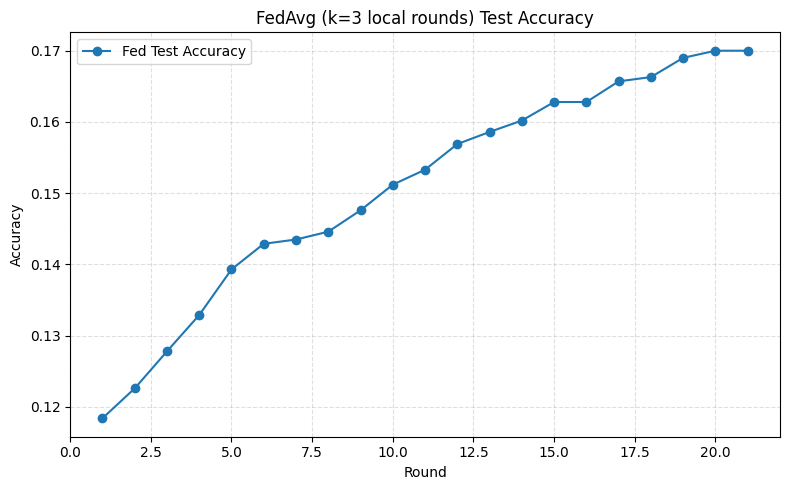

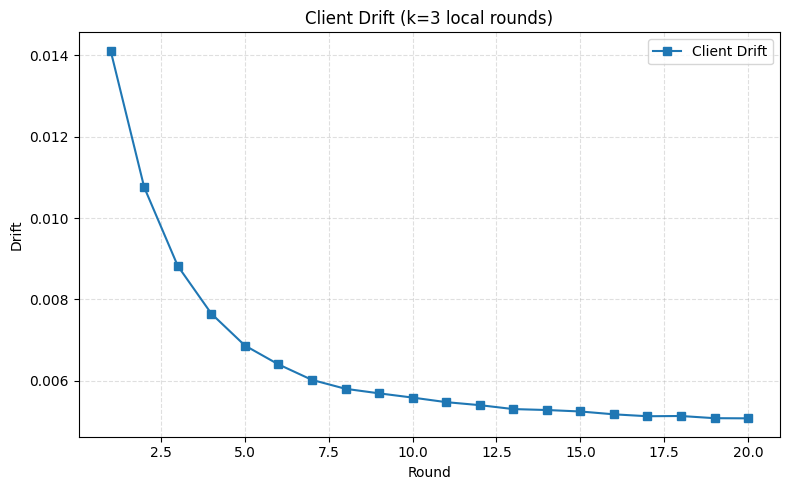

In [13]:
f = fed_avg_exp(local_runs=3)
plot_fed_test_acc(f.federated_method.round_metrics, f"FedAvg (k={3} local rounds) Test Accuracy")
plot_client_drift(f.federated_method.round_metrics, f"Client Drift (k={3} local rounds)")


--- Round 1/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 1:


FedAvg  | Test Loss: 2.3181, Test Acc: 11.19%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 1.806403e-02

--- Round 2/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 2:


FedAvg  | Test Loss: 2.3027, Test Acc: 11.64%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 2.969412e-02

--- Round 3/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 3:


FedAvg  | Test Loss: 2.2883, Test Acc: 12.45%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 3.876026e-02

--- Round 4/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 4:


FedAvg  | Test Loss: 2.2748, Test Acc: 13.27%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 4.681684e-02

--- Round 5/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs


Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 5:


FedAvg  | Test Loss: 2.2631, Test Acc: 13.71%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 5.443351e-02

--- Round 6/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 6:


FedAvg  | Test Loss: 2.2497, Test Acc: 14.34%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 6.191519e-02

--- Round 7/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 7:


FedAvg  | Test Loss: 2.2387, Test Acc: 15.06%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 6.935886e-02

--- Round 8/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 8:


FedAvg  | Test Loss: 2.2255, Test Acc: 15.92%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 7.674591e-02

--- Round 9/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 9:


FedAvg  | Test Loss: 2.2157, Test Acc: 16.66%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 8.405411e-02

--- Round 10/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs


Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 10:


FedAvg  | Test Loss: 2.2012, Test Acc: 17.66%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 9.136399e-02

--- Round 11/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 11:


FedAvg  | Test Loss: 2.1897, Test Acc: 18.40%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 9.866565e-02

--- Round 12/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs


Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 12:


FedAvg  | Test Loss: 2.1808, Test Acc: 19.09%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 1.058595e-01

--- Round 13/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 13:


FedAvg  | Test Loss: 2.1684, Test Acc: 19.85%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 1.130453e-01

--- Round 14/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 14:


FedAvg  | Test Loss: 2.1575, Test Acc: 20.60%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 1.200857e-01

--- Round 15/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 15:


FedAvg  | Test Loss: 2.1485, Test Acc: 20.94%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 1.271143e-01

--- Round 16/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs


Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 16:


FedAvg  | Test Loss: 2.1396, Test Acc: 21.32%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 1.340133e-01

--- Round 17/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 17:


FedAvg  | Test Loss: 2.1306, Test Acc: 21.57%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 1.408265e-01

--- Round 18/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 18:


FedAvg  | Test Loss: 2.1208, Test Acc: 22.18%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 1.475999e-01

--- Round 19/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 19:


FedAvg  | Test Loss: 2.1051, Test Acc: 23.22%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 1.542196e-01

--- Round 20/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Client 3/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 20:


FedAvg  | Test Loss: 2.1034, Test Acc: 22.96%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 1.607805e-01
Training Complete!


FedAvg  | Test Loss: 2.1034, Test Acc: 22.96%
Central | Test Loss: 2.3037, Test Acc: 10.00%
Param Difference: 1.607805e-01


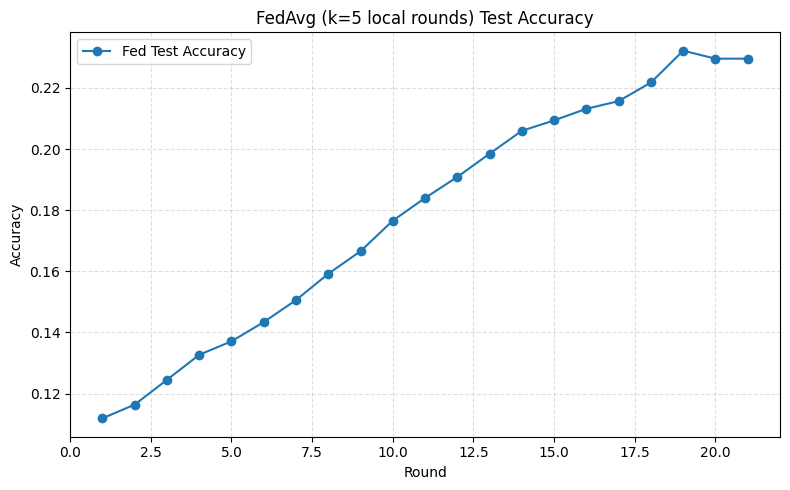

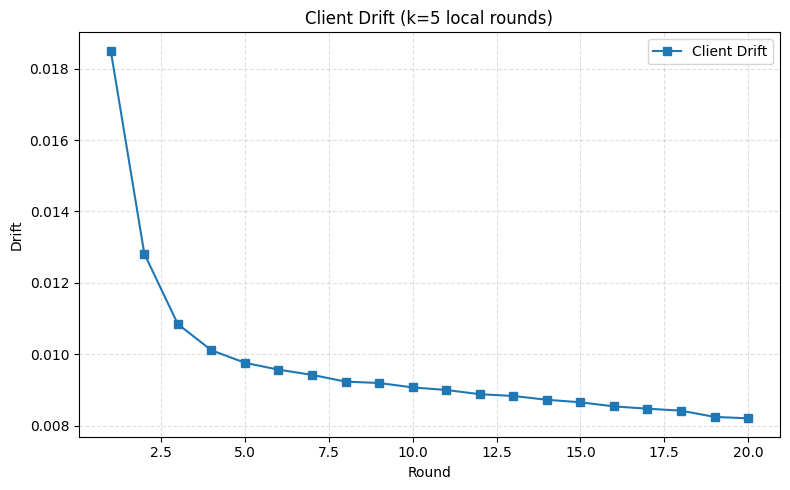

In [14]:
f = fed_avg_exp(local_runs=5)
plot_fed_test_acc(f.federated_method.round_metrics, f"FedAvg (k={5} local rounds) Test Accuracy")
plot_client_drift(f.federated_method.round_metrics, f"Client Drift (k={5} local rounds)")


--- Round 1/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs
Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 1:


FedAvg  | Test Loss: 2.2996, Test Acc: 11.64%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 2.568814e-02

--- Round 2/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs


Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 2:


FedAvg  | Test Loss: 2.2641, Test Acc: 13.64%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 4.481339e-02

--- Round 3/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs


Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 3:


FedAvg  | Test Loss: 2.2342, Test Acc: 15.92%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 6.154168e-02

--- Round 4/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs
Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 4:


FedAvg  | Test Loss: 2.2085, Test Acc: 18.13%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 7.714070e-02

--- Round 5/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs
Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 5:


FedAvg  | Test Loss: 2.1838, Test Acc: 19.68%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 9.190941e-02

--- Round 6/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs
Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 6:


FedAvg  | Test Loss: 2.1617, Test Acc: 20.92%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 1.063760e-01

--- Round 7/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs
Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 7:


FedAvg  | Test Loss: 2.1425, Test Acc: 21.79%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 1.204486e-01

--- Round 8/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs
Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 8:


FedAvg  | Test Loss: 2.1194, Test Acc: 22.64%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 1.341601e-01

--- Round 9/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs
Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 9:


FedAvg  | Test Loss: 2.1042, Test Acc: 22.80%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 1.473146e-01

--- Round 10/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs


Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 10:


FedAvg  | Test Loss: 2.0849, Test Acc: 23.33%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 1.601688e-01

--- Round 11/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs
Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 11:


FedAvg  | Test Loss: 2.0716, Test Acc: 23.30%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 1.724461e-01

--- Round 12/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs


Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 12:


FedAvg  | Test Loss: 2.0587, Test Acc: 23.39%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 1.844477e-01

--- Round 13/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs
Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 13:


FedAvg  | Test Loss: 2.0405, Test Acc: 23.98%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 1.959066e-01

--- Round 14/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs
Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 14:


FedAvg  | Test Loss: 2.0287, Test Acc: 24.18%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 2.069672e-01

--- Round 15/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs
Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 15:


FedAvg  | Test Loss: 2.0154, Test Acc: 24.49%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 2.177635e-01

--- Round 16/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs


Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 16:


FedAvg  | Test Loss: 2.0051, Test Acc: 24.68%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 2.282070e-01

--- Round 17/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs
Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 17:


FedAvg  | Test Loss: 1.9928, Test Acc: 24.98%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 2.381122e-01

--- Round 18/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs
Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 18:


FedAvg  | Test Loss: 1.9792, Test Acc: 25.50%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 2.476835e-01

--- Round 19/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs


Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 19:


FedAvg  | Test Loss: 1.9712, Test Acc: 25.54%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 2.570232e-01

--- Round 20/20 ---
Training Clients
Selected 5/5 clients: [3, 4, 0, 1, 2]
Training Client 4/5 for 10 epochs
Training Client 5/5 for 10 epochs
Training Client 1/5 for 10 epochs
Training Client 2/5 for 10 epochs
Training Client 3/5 for 10 epochs
Training Server
Aggregating 5 clients
Evaluate on round 20:


FedAvg  | Test Loss: 1.9570, Test Acc: 26.22%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 2.660699e-01
Training Complete!


FedAvg  | Test Loss: 1.9570, Test Acc: 26.22%
Central | Test Loss: 2.3039, Test Acc: 10.00%
Param Difference: 2.660699e-01


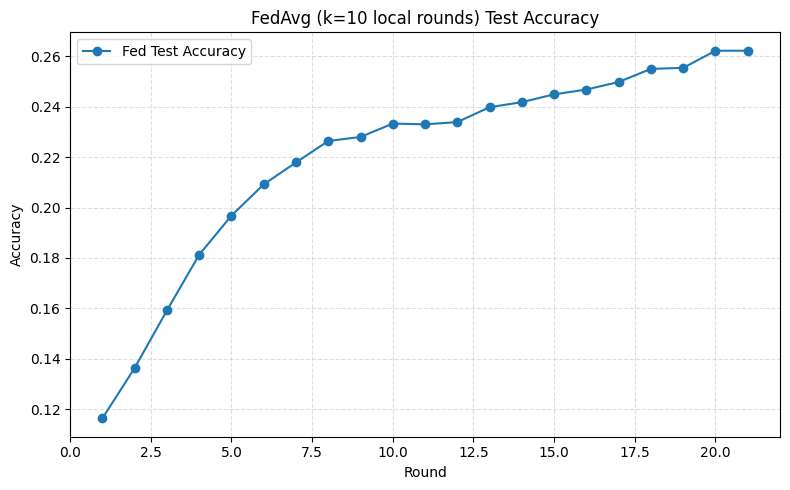

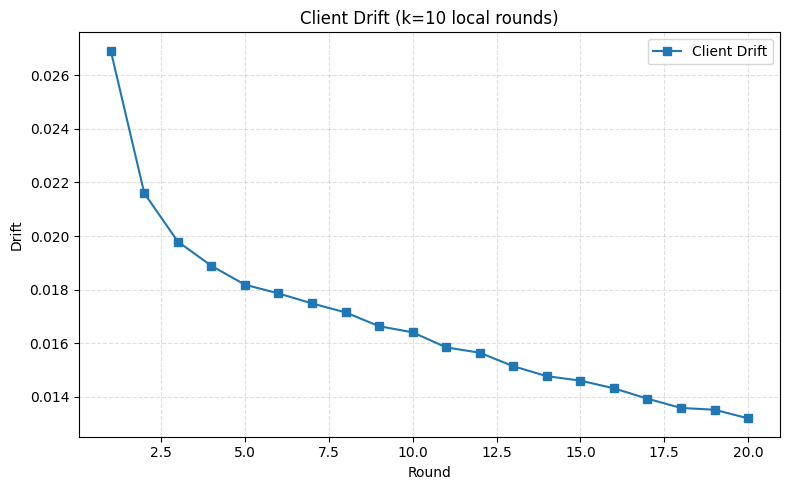

In [15]:
f = fed_avg_exp(local_runs=10)
plot_fed_test_acc(f.federated_method.round_metrics, f"FedAvg (k={10} local rounds) Test Accuracy")
plot_client_drift(f.federated_method.round_metrics, f"Client Drift (k={10} local rounds)")

In [16]:
f = fed_avg_exp(sampling_frac=0.8)
plot_fed_test_acc(f.federated_method.round_metrics, f"FedAvg (sampling fraction = 0.8) Test Accuracy")
plot_client_drift(f.federated_method.round_metrics, f"Client Drift (sampling fraction = 0.8)")


--- Round 1/20 ---
Training Clients
Selected 4/5 clients: [3, 4, 0, 1]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 1:


FedAvg  | Test Loss: 2.3041, Test Acc: 10.61%
Central | Test Loss: 2.3038, Test Acc: 10.00%
Param Difference: 3.967125e+00

--- Round 2/20 ---
Training Clients
Selected 4/5 clients: [3, 4, 0, 1]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 2:


FedAvg  | Test Loss: 2.3041, Test Acc: 10.12%
Central | Test Loss: 2.3038, Test Acc: 10.00%
Param Difference: 7.140739e+00

--- Round 3/20 ---
Training Clients
Selected 4/5 clients: [3, 4, 0, 1]
Training Client 4/5 for 5 epochs


Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 3:


FedAvg  | Test Loss: 2.3042, Test Acc: 10.04%
Central | Test Loss: 2.3038, Test Acc: 10.00%
Param Difference: 9.679586e+00

--- Round 4/20 ---
Training Clients
Selected 4/5 clients: [3, 4, 0, 1]
Training Client 4/5 for 5 epochs


Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 4:


FedAvg  | Test Loss: 2.3044, Test Acc: 10.10%
Central | Test Loss: 2.3038, Test Acc: 10.00%
Param Difference: 1.171064e+01

--- Round 5/20 ---
Training Clients
Selected 4/5 clients: [3, 4, 0, 1]
Training Client 4/5 for 5 epochs


Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 5:


FedAvg  | Test Loss: 2.3041, Test Acc: 10.12%
Central | Test Loss: 2.3038, Test Acc: 10.00%
Param Difference: 1.333548e+01

--- Round 6/20 ---
Training Clients
Selected 4/5 clients: [3, 4, 0, 1]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 6:


FedAvg  | Test Loss: 2.3039, Test Acc: 10.03%
Central | Test Loss: 2.3038, Test Acc: 10.00%
Param Difference: 1.463535e+01

--- Round 7/20 ---
Training Clients
Selected 4/5 clients: [3, 4, 0, 1]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 7:


FedAvg  | Test Loss: 2.3036, Test Acc: 10.00%
Central | Test Loss: 2.3038, Test Acc: 10.00%
Param Difference: 1.567523e+01

--- Round 8/20 ---
Training Clients
Selected 4/5 clients: [3, 4, 0, 1]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 8:


FedAvg  | Test Loss: 2.3035, Test Acc: 10.00%
Central | Test Loss: 2.3038, Test Acc: 10.00%
Param Difference: 1.650713e+01

--- Round 9/20 ---
Training Clients
Selected 4/5 clients: [3, 4, 0, 1]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 9:


FedAvg  | Test Loss: 2.3034, Test Acc: 10.00%
Central | Test Loss: 2.3038, Test Acc: 10.00%
Param Difference: 1.717266e+01

--- Round 10/20 ---
Training Clients
Selected 4/5 clients: [3, 4, 0, 1]
Training Client 4/5 for 5 epochs


Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 10:


FedAvg  | Test Loss: 2.3033, Test Acc: 10.00%
Central | Test Loss: 2.3038, Test Acc: 10.00%
Param Difference: 1.770506e+01

--- Round 11/20 ---
Training Clients
Selected 4/5 clients: [3, 4, 0, 1]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 11:


FedAvg  | Test Loss: 2.3033, Test Acc: 10.00%
Central | Test Loss: 2.3038, Test Acc: 10.00%
Param Difference: 1.813099e+01

--- Round 12/20 ---
Training Clients
Selected 4/5 clients: [3, 4, 0, 1]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 12:


FedAvg  | Test Loss: 2.3033, Test Acc: 10.00%
Central | Test Loss: 2.3038, Test Acc: 10.00%
Param Difference: 1.847172e+01

--- Round 13/20 ---
Training Clients
Selected 4/5 clients: [3, 4, 0, 1]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 13:


FedAvg  | Test Loss: 2.3032, Test Acc: 10.00%
Central | Test Loss: 2.3038, Test Acc: 10.00%
Param Difference: 1.874430e+01

--- Round 14/20 ---
Training Clients
Selected 4/5 clients: [3, 4, 0, 1]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 14:


FedAvg  | Test Loss: 2.3032, Test Acc: 10.00%
Central | Test Loss: 2.3038, Test Acc: 10.00%
Param Difference: 1.896236e+01

--- Round 15/20 ---
Training Clients
Selected 4/5 clients: [3, 4, 0, 1]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 15:


FedAvg  | Test Loss: 2.3032, Test Acc: 10.00%
Central | Test Loss: 2.3038, Test Acc: 10.00%
Param Difference: 1.913682e+01

--- Round 16/20 ---
Training Clients
Selected 4/5 clients: [3, 4, 0, 1]
Training Client 4/5 for 5 epochs
Training Client 5/5 for 5 epochs
Training Client 1/5 for 5 epochs
Training Client 2/5 for 5 epochs
Training Server
Aggregating 5 clients
Evaluate on round 16:


FedAvg  | Test Loss: 2.3031, Test Acc: 10.00%
Central | Test Loss: 2.3038, Test Acc: 10.00%
Param Difference: 1.927637e+01

--- Round 17/20 ---
Training Clients
Selected 4/5 clients: [3, 4, 0, 1]
Training Client 4/5 for 5 epochs


KeyboardInterrupt: 

In [ ]:
f = fed_avg_exp(sampling_frac=0.5)
plot_fed_test_acc(f.federated_method.round_metrics, f"FedAvg (sampling fraction = 0.5) Test Accuracy")
plot_client_drift(f.federated_method.round_metrics, f"Client Drift (sampling fraction = 0.5)")

In [ ]:
f = fed_avg_exp(sampling_frac=0.2)
plot_fed_test_acc(f.federated_method.round_metrics, f"FedAvg (sampling fraction = 0.2) Test Accuracy")
plot_client_drift(f.federated_method.round_metrics, f"Client Drift (sampling fraction = 0.2)")